In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import math
import random

## Task 1: Custom Neural Network
Here I implement a basic neural network. It Only has functionality for a basic feed forward network with the non-linearity only being the
ReLU function. I allow for the back-propagation step to include momentum. I didn't build the network to be very general in terms of
how I handle the gradient information. Torch packs the gradient and the tensor data in one datatype and the optimizer collects all these parameters so that it can any general updating scheme. Here however I don't collect them and just leave them as class variables. I also do the update within the class rather then using an outside "optimizer".

In [2]:
class linear():
    def __init__(self, in_dims, out_dims):
        self.w = np.zeros((in_dims, out_dims))
        self.b = np.zeros(out_dims)
        self.out_dims = out_dims
        self.in_dims = in_dims
        self.dW = np.zeros(self.w.shape)
        self.dB = np.zeros(self.b.shape)
        self.dX = None
        self.cached_X = None
        self.back_count=0
        self.init_weights()
    def __call__(self, x):
        #x = (batch, in_dims)
        self.cached_X = np.copy(x.T)
        return x@self.w + self.b
        
    def back(self, dL, gamma):
        self.back_count+=1
        self.dW = gamma*self.dW + (1-gamma)*self.cached_X@dL 
        self.dB = gamma*self.dB + (1-gamma)*np.sum(dL, axis=0) 
        if (self.dX is None):
            self.dX = np.zeros(self.cached_X.T.shape)
        self.dX = gamma*self.dX + (1-gamma)*dL@self.w.T
        return self.dX
    def init_weights(self):
        k = 1/self.in_dims
        self.w = np.random.uniform(-np.sqrt(k), np.sqrt(k), size=self.w.shape)
        self.b = np.random.uniform(-np.sqrt(k), np.sqrt(k), size=self.b.shape)
    def update(self, lr):
        self.w = self.w - lr * self.dW
        self.b = self.b - lr * self.dB

class relu():
    def __init__(self):
        self.dX = None
    def __call__(self, x):
        self.dX = x>0
        return self.dX*x
    def back(self, dL, gamma):
        self.dX = dL*self.dX
        return self.dX
    def update(self, lr):
        pass

"""
class softmax():
    self.dX = None
    def __call__(self, x):
        self.dX = x
        return np.exp(x)/np.sum(np.exp(x), keep_dims=True)
    def back(self):

"""     

def MSE(y_hat, y):
    #Returns Loss, dLoss/dy_hat
    return (1/y_hat.shape[0]) * (y_hat-y).T @ (y_hat-y), 2*(y_hat-y)
        

In [3]:
class NeuralNetwork():
    def __init__(self, dimensions, out_activation):
        self.nn = []
        for dimension in dimensions:
            self.nn.append(linear(dimension[0], dimension[1]))
            self.nn.append(relu())
        self.nn.pop()
        if out_activation != None:
            self.nn.append(out_activation())
    def __call__(self, x):
        for layer in self.nn:
            x = layer(x)
        return x
    def back(self, dL, gamma):
        for layer in reversed(self.nn):
            dL = layer.back(dL, gamma)
    def update(self, lr):
        for layer in self.nn:
            layer.update(lr)


## Testing the model
Here I test that the model actually works and can learn basic functions. Here I test it with the sin function and learn that my model is extremely sensetive to hyperparameters such as batch_size, learning rate and gamma (momentum). In the end I found hyperparameters that result in my network learning well. I compare it to a simple pytorch built in model as well. I also do not utilize a train/test set split
since we already have access to the data generating function/distribution. This is simply to test the models ability to learn.

In [4]:
nn = NeuralNetwork([[1,10],[10,1]], None)
for i in range(100000):
    x_dset = (3.141592/2 + np.random.randn(200,1))*3
    y_dset = np.sin(x_dset).reshape(-1, 1)
    out = nn(x_dset)
    loss, dL = MSE(out, y_dset)
    nn.back(dL, 0.3)
    nn.update(0.0001)
print(loss)




[[0.24602585]]


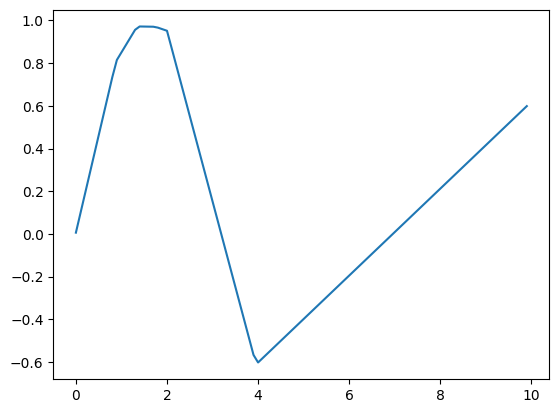

In [5]:
test = np.arange(0,10, 0.1).reshape(-1,1)
predictions = nn((test))
plt.plot(test,predictions)

In [6]:
t_nn = torch.nn.Sequential(torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1))

In [7]:
optim = torch.optim.Adam(params = t_nn.parameters())
loss = torch.nn.MSELoss()

In [8]:
for _ in range(50000):
    x_dset = torch.Tensor((3.141592/2 + np.random.randn(200,1))*3)
    y_dset = torch.Tensor(np.sin(x_dset).reshape(-1, 1))
    optim.zero_grad()
    y_hat = t_nn(x_dset)
    l = loss(y_hat, y_dset)
    l.backward()
    optim.step()
print(l.item())

0.2556103765964508


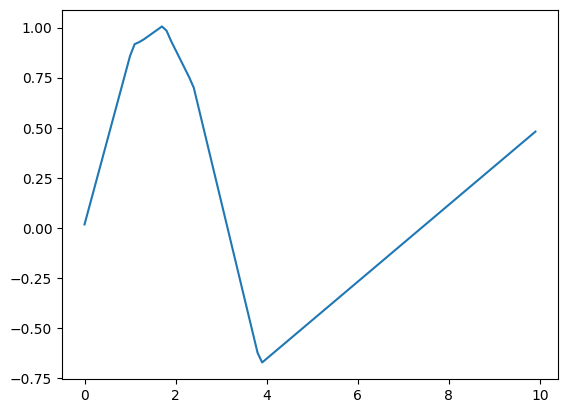

In [9]:
t_nn.eval()
t_predictions = t_nn(torch.Tensor(test))
plt.plot(test,t_predictions.detach())

## Network Using PyTorch
Here I implement a basic Neural Network using torch. We are building every layer from "scratch" using torch, meaning we will not use pre-built modules and optimizers. Torch automatically deals with differentation thus I just have to define the forward propagation of the module the loss function and the optimizer. This allows for really quick development of models, loss functions and optimizers as all you need to specify is how the input is transformed to the output.

## Resources Used to learn torch
https://pytorch.org/docs/stable/generated/torch.nn.Module.html \
These are the docs for the nn.Module base class from which all modules are built upon. \
https://pytorch.org/docs/stable/tensors.html \
This helped me get more familair with torch's Tensor Type which is very simular to a numpy array. \
https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD \
This source code served as a guide for me to make my own optimizer using torch. 


In [173]:
class torchLinear(torch.nn.Module):
    def __init__(self, in_dims, out_dims):
        super().__init__()
        self.w = torch.nn.Parameter(torch.zeros(in_dims, out_dims))
        self.b = torch.nn.Parameter(torch.zeros(out_dims))
        self.k = in_dims
        
    def initialize(self):
        sqrt_k = math.sqrt(self.k)
        self.w = torch.nn.Parameter(torch.rand(*self.w.shape, requires_grad=True) * (2*sqrt_k) - sqrt_k)
        self.b = torch.nn.Parameter(torch.rand(*self.b.shape, requires_grad=True) * (2*sqrt_k) - sqrt_k)

    def forward(self, x):
        return x@self.w + self.b

class torchReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x* (x>0)

    def initialize(self):
        return
        
    
class torchNetwork(torch.nn.Module):
    def __init__(self, dimensions, out_activation):
        super().__init__()
        self.network = []
        for dim in dimensions:
            self.network.append(torchLinear(dim[0], dim[1]))
            self.network.append(torchReLU())
        self.network.pop()
        self.network = torch.nn.ModuleList(self.network)
        if out_activation != None:
            self.network.append(out_activation())
        
    def initialize(self):
        for layer in self.network:
            layer.initialize()
    
    def forward(self, x):
        for layer in self.network:
            x = layer(x)
        return x

class torchSigmoid(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 1/(1+torch.exp(-x))
        
class torchSoftmax(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.exp(x)/(torch.exp(x).sum(dim=1, keepdim=True) + 3e-3)
        
class torchMSE(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_hat, y):
        return (1/y_hat.shape[0]) * (y_hat-y).T @ (y_hat-y)

class torchCE(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_hat, y):
        classes = torch.max(y)
        l = torch.zeros(1)
        for c in range(int(classes.item())):
            l -= ((y==c)*torch.log(y_hat)[:, c]).sum()
        return (1/y.shape[0]) * l
        
class torchSGD(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, gamma=0.9):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)
        self.gamma = gamma
        self.param_momentum = dict()
        for g in self.param_groups: 
            for parameter in g['params']: 
                self.param_momentum[parameter] = torch.zeros(*parameter.data.shape)
    def step(self):
        for g in self.param_groups:
            for parameter in g['params']:
                momentum = self.param_momentum[parameter]
                momentum = self.gamma * momentum + (1-self.gamma) * parameter.grad.data
                self.param_momentum[parameter] = momentum
                parameter.data -= g['lr'] * momentum
        
                    

In [11]:
net_2= torchNetwork([(1, 10) , (10, 1)], None)
net_2.initialize()
print(list(net_2.network[0].parameters()))
optim = torchSGD(lr=3e-3, params = net_2.parameters())
loss = torchMSE()

[Parameter containing:
tensor([[-0.5614,  0.6098, -0.2727, -0.8580,  0.2519,  0.2558,  0.0450, -0.8549,
         -0.8127,  0.7565]], requires_grad=True), Parameter containing:
tensor([-0.5367, -0.0792,  0.1318,  0.2176, -0.2050,  0.5791,  0.9469, -0.2436,
        -0.1476,  0.1846], requires_grad=True)]


In [12]:
for _ in range(50000):
    x_dset = torch.Tensor((3.141592/2 + np.random.randn(500,1))*3)
    y_dset = torch.Tensor(np.sin(x_dset).reshape(-1, 1))
    optim.zero_grad()
    y_hat = net_2(x_dset)
    l = loss(y_hat, y_dset)
    l.backward()
    optim.step()
print(l.item())

0.24981987476348877


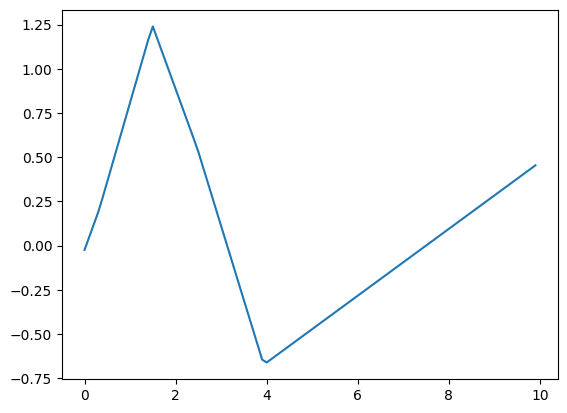

In [13]:
test = np.arange(0,10, 0.1).reshape(-1,1)
predictions = net_2(torch.Tensor(test))
plt.plot(test,predictions.detach())

## Wine Quality
Dataset: http://archive.ics.uci.edu/dataset/186/wine+quality
We are going to try and learn the how to predict the quality of wine (classification 1-10) with regaurd to different chemical features of that wine. This is a good test dataset as it is not too large but also large enough that our neural network can learn "hopefully" well.

In [57]:
def create_datapoint(entry):
    y = [int(entry.pop())]
    entry = [float(val) for val in entry]
    return entry, y



In [58]:
f = open("winequality-white.csv")
lines = f.readlines()[1:]
dset = []
for line in lines:
    line = line.strip()
    data = line.split(';')
    dset.append(create_datapoint(data))
random.shuffle(dset)

In [59]:
print(len(dset))

4897


In [60]:
X = [entry[0] for entry in dset]
Y = [entry[1] for entry in dset]

In [61]:
TEST_SIZE=100
VAL_SIZE=750
test_set = (X[:TEST_SIZE], Y[:TEST_SIZE])
val_set = (X[TEST_SIZE: VAL_SIZE+TEST_SIZE], Y[TEST_SIZE: VAL_SIZE+TEST_SIZE])
X = torch.Tensor((X[TEST_SIZE+VAL_SIZE:]))
Y = torch.Tensor(Y[TEST_SIZE+VAL_SIZE:])
X.shape

torch.Size([4047, 11])

In [198]:
def train(model, X,Y, epochs, batch_size, loss, optim):
    for _ in range(epochs):
        l_sum = 0
        for b in range(len(X)//batch_size):
            batched_X = X[b*batch_size: (b+1)*batch_size]
            batched_Y = Y[b*batch_size: (b+1)*batch_size]
            optim.zero_grad()
            y_hat = model(batched_X)
            l = loss(y_hat, batched_Y)
            l.backward()
            optim.step()
            l_sum+=l.item()
        print(l_sum/(len(X)//batch_size))
        l_sum=0
    return model

def accuracy(model, X, Y):
    model.eval()
    y_hat = model(X)
    y_hat = torch.argmax(y_hat, dim=1)
    model.train()
    Y = Y.reshape(-1)
    return ((y_hat == Y).sum()/Y.shape[0]).item()
    


In [216]:
model= torchNetwork([(11, 256) , (256, 10)], torchSoftmax)
optim = torchSGD(params=model.parameters(), lr=0.00001)
loss = torchCE()
batch_size=128
epochs=1000

In [217]:
train(model, X, Y, epochs, batch_size, loss, optim)

284.48323206747733
283.4212173954133
282.2697566863029
281.1235164519279
279.9861302529612
278.8576847199471
277.73824777910784
276.62777513073337
275.5262726814516
274.4337345246346
273.3501508159022
272.27552450856854
271.20983197612145
270.15306928080895
269.10521574943294
268.06626645980344
267.03622141192034
266.01502843056954
265.002693422379
263.9991947297127
263.00450085055445
262.01860981602823
261.04147388089086
260.0730905840474
259.1134299001386
258.16245835827243
257.22014987084174
256.28648179577243
255.36142804545742
254.44492856917842
253.53697992140246
252.6375491234564
251.746580062374
250.86404615832913
249.98992772256173
249.12415781328755
248.26671477287047
247.41756070044732
246.57664538967995
245.74392995526713
244.9193607453377
244.10292102444558
243.29454778855848
242.4941932924332
241.70181323635964
240.9173623361895
240.14079137002267
239.37205899146295
238.6111095797631
237.85787914645286
237.11233766617315
236.37441918157762
235.64407053301412
234.921251850

torchNetwork(
  (network): ModuleList(
    (0): torchLinear()
    (1): torchReLU()
    (2): torchLinear()
    (3): torchSoftmax()
  )
)

In [222]:
accuracy(model, X,Y), accuracy(model, torch.Tensor(test_set[0]),torch.Tensor(test_set[1]))

(0.4514455199241638, 0.4099999964237213)

In [ ]:
##